In [1]:
import pandas as pd
import numpy as np
import time
import os
from pathlib import Path
import base64
from IPython.display import HTML, display
from keras import Sequential
from keras import layers
from keras import regularizers
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
os.getcwd()

'C:\\Users\\i318517\\Desktop\\MSC\\Machine Learning\\CA684_Assignment'

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'CA684 Assignment_Overview',
 'CA684 Assignment_Overview-20210319T235625Z-001.zip',
 'Dev-set',
 'Dev-set.zip',
 'interim-layout.docx',
 'Kushagra_Srivastava_ 20214989_predicting_memorability.ipynb',
 'Media Memorability Prediction.ipynb',
 'Test-set',
 'Test-set-20210423T193446Z-001.zip',
 'Tutorials',
 'Tutorials-20210320T000635Z-001.zip',
 '~WRL3281.tmp']

In this notebook we first built model on individual features namely C3D, HMP and aesthetic features and then we later combine the features to built new models and compare the performance of one model against the other.

In [4]:
ground_truth_file = 'C:\\Users\\i318517\\Desktop\\MSC\\Machine Learning\\CA684_Assignment\\Dev-set\\Ground-truth\\ground-truth.csv'
#ground_truth_file = r"C:\Users\i318517\Desktop\MSC\Machine Learning\CA684_Assignment\Dev-set\Ground-truth\ground-truth_dev-set.csv"
labels = pd.read_csv(ground_truth_file)
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [5]:
labels.describe()

,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.860243,36.291500,0.778941,12.764667
std,0.080655,8.356285,0.144692,3.544815
min,0.388000,30.000000,0.000000,9.000000
25%,0.811000,33.000000,0.700000,10.000000
50%,0.867000,34.000000,0.800000,12.000000
75%,0.923000,34.000000,0.900000,14.000000
max,0.989000,100.000000,1.000000,40.000000


In [6]:
vid = labels.video.values

In [7]:
# get spearman score
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# C3D Features

Extraction training and validation of C3D features

In [8]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D


In [9]:
C3D_Feat_path = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Dev-set/'
C3D_Features = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D(C3D_Feat_path+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })


In [10]:
C3D_Features.head()

,video,C3D
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."
2,video6.webm,"[0.01176522, 0.00074577, 0.00078353, 1.328e-05..."
3,video8.webm,"[0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ..."
4,video10.webm,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092..."


In [10]:
C3D_X = np.stack(C3D_Features['C3D'].values)
C3D_Y = labels[['short-term_memorability','long-term_memorability']].values

In [11]:
#split into train and test set for training and validation
C3D_X_train, C3D_X_test, C3D_Y_train, C3D_Y_test = train_test_split(C3D_X,C3D_Y, test_size=0.2, random_state=42)

FIRST RUN results : 
The Spearman's correlation coefficient is: 0.31
The Spearman's correlation coefficient is: 0.114

In [12]:
#random forest C3D (SECOND RUN)
from sklearn.ensemble import RandomForestRegressor
C3D_clf = RandomForestRegressor()
C3D_clf.fit(C3D_X_train,C3D_Y_train)
pred_test_rfr = C3D_clf.predict(C3D_X_test)
Get_score(pred_test_rfr, C3D_Y_test)

The Spearman's correlation coefficient is: 0.327
The Spearman's correlation coefficient is: 0.099


# HMP Features

Extraction training and validation of HMP features

In [13]:
#HMP features
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [14]:
HMP_Feat_path = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values
HMP_Features = pd.DataFrame({'video': vid,
                   'HMP': [read_HMP(HMP_Feat_path+'HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [15]:
HMP_Features.head()

,video,HMP
0,video3.webm,"[0.125563, 0.024036, 0.000314, 0.0, 0.015864, ..."
1,video4.webm,"[0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0..."
2,video6.webm,"[0.109584, 0.018978, 0.000289, 0.0, 0.008774, ..."
3,video8.webm,"[0.120431, 0.013561, 0.000277, 0.0, 0.018974, ..."
4,video10.webm,"[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2..."


In [16]:
HMP_X = np.stack(HMP_Features['HMP'].values)
HMP_Y = labels[['short-term_memorability','long-term_memorability']].values
HMP_X_train, HMP_X_test, HMP_Y_train, HMP_Y_test = train_test_split(HMP_X,HMP_Y, test_size=0.2, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestRegressor
HMP_clf = RandomForestRegressor()
HMP_clf.fit(HMP_X_train,HMP_Y_train)
pred_test_rfr = HMP_clf.predict(HMP_X_test)
Get_score(pred_test_rfr, HMP_Y_test)

The Spearman's correlation coefficient is: 0.295
The Spearman's correlation coefficient is: 0.112


# Aesthetic features

The aesthetic features have been aggregated by mean and median. I have extracted each of the features and built separate
models on them.The results showed that the long term memorability for model trained on mean features were significantly better the long term memorability for model trained with median features.

In [37]:
#function to read aethetic features
def read_aesthetic_features(fname):
    #Scan vectors from file
    with open(fname) as f:
        for line in f:
            aesthetic =[float(item) for item in line.split(',')] # convert to float type, using default separator
    return aesthetic


In [38]:
#load aesthetic features 
aesthetic_path = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Dev-set/Aesthetic_Features/dev-set_aesthetic-features/features/aesthetic_visual_features/'
vid = labels.video.values
# read the mean aesthetic features
aesthetic_features_mean = pd.DataFrame({'video': vid,
                   'aesthetic_mean': [read_aesthetic_features(aesthetic_path+'aesthetic_feat_dev-set_mean'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [39]:
aesthetic_features_mean.head()

,video,aesthetic_mean
0,video3.webm,"[0.18389, 0.713733, 0.202302, 0.610132, 0.1242..."
1,video4.webm,"[0.147255, 0.550718, 0.460299, 0.424981, 0.341..."
2,video6.webm,"[0.063933, 0.826933, 0.214129, 0.719341, 0.130..."
3,video8.webm,"[0.367527, 0.133869, 0.746074, 0.169317, 0.696..."
4,video10.webm,"[0.402878, 0.389358, 0.564687, 0.400378, 0.471..."


In [40]:
#load median features
aesthetic_features_median = pd.DataFrame({'video': vid,
                   'aesthetic_median': [read_aesthetic_features(aesthetic_path+'aesthetic_feat_dev-set_median'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [41]:
aesthetic_features_median.head()

,video,aesthetic_median
0,video3.webm,"[0.180874, 0.715626, 0.19893, 0.610453, 0.1216..."
1,video4.webm,"[0.146076, 0.55007, 0.460729, 0.424397, 0.3418..."
2,video6.webm,"[0.063898, 0.827439, 0.211925, 0.720297, 0.129..."
3,video8.webm,"[0.380539, 0.134683, 0.746891, 0.171604, 0.697..."
4,video10.webm,"[0.427258, 0.381448, 0.582746, 0.409475, 0.489..."


In [42]:
aesthetic_features = pd.merge(aesthetic_features_mean, aesthetic_features_median, on='video')
aesthetic_features.head()

,video,aesthetic_mean,aesthetic_median
0,video3.webm,"[0.18389, 0.713733, 0.202302, 0.610132, 0.1242...","[0.180874, 0.715626, 0.19893, 0.610453, 0.1216..."
1,video4.webm,"[0.147255, 0.550718, 0.460299, 0.424981, 0.341...","[0.146076, 0.55007, 0.460729, 0.424397, 0.3418..."
2,video6.webm,"[0.063933, 0.826933, 0.214129, 0.719341, 0.130...","[0.063898, 0.827439, 0.211925, 0.720297, 0.129..."
3,video8.webm,"[0.367527, 0.133869, 0.746074, 0.169317, 0.696...","[0.380539, 0.134683, 0.746891, 0.171604, 0.697..."
4,video10.webm,"[0.402878, 0.389358, 0.564687, 0.400378, 0.471...","[0.427258, 0.381448, 0.582746, 0.409475, 0.489..."


In [43]:
# split train and test data
aes_mean_X = np.stack(aesthetic_features['aesthetic_mean'].values)
aes_mean_Y = labels[['short-term_memorability','long-term_memorability']].values
aes_mean_X_train, aes_mean_X_test, aes_mean_Y_train, aes_mean_Y_test = train_test_split(aes_mean_X,aes_mean_Y, test_size=0.2, random_state=42)

In [44]:
# built and train on aethetic mean features(SECOND RUN)
aes_mean_clf = RandomForestRegressor()
aes_mean_clf.fit(aes_mean_X_train,aes_mean_Y_train)
pred_test_aes_mean = aes_mean_clf.predict(aes_mean_X_test)
Get_score(pred_test_aes_mean, aes_mean_Y_test)

The Spearman's correlation coefficient is: 0.286
The Spearman's correlation coefficient is: 0.134


In [40]:
# built and train on aethetic mean features(FIRST RUN)
aes_mean_clf = RandomForestRegressor()
aes_mean_clf.fit(aes_mean_X_train,aes_mean_Y_train)
pred_test_aes_mean = aes_mean_clf.predict(aes_mean_X_test)
Get_score(pred_test_aes_mean, aes_mean_Y_test)

The Spearman's correlation coefficient is: 0.310
The Spearman's correlation coefficient is: 0.133


In [45]:
aes_median_X = np.stack(aesthetic_features['aesthetic_median'].values)
aes_median_Y = labels[['short-term_memorability','long-term_memorability']].values
aes_median_X_train, aes_median_X_test, aes_median_Y_train, aes_median_Y_test = train_test_split(aes_median_X,aes_median_Y, test_size=0.2, random_state=42)

In [46]:
#built and train on aesthetic median features(SECOND RUN)
from sklearn.ensemble import RandomForestRegressor
aes_median_clf = RandomForestRegressor()
aes_median_clf.fit(aes_median_X_train,aes_median_Y_train)
pred_test_aes_median = aes_median_clf.predict(aes_median_X_test)
Get_score(pred_test_aes_median, aes_median_Y_test)

The Spearman's correlation coefficient is: 0.312
The Spearman's correlation coefficient is: 0.120


In [45]:
#built and train on aesthetic median features(FIRST RUN)
from sklearn.ensemble import RandomForestRegressor
aes_median_clf = RandomForestRegressor()
aes_median_clf.fit(aes_median_X_train,aes_median_Y_train)
pred_test_aes_median = aes_median_clf.predict(aes_median_X_test)
Get_score(pred_test_aes_median, aes_median_Y_test)

The Spearman's correlation coefficient is: 0.303
The Spearman's correlation coefficient is: 0.087


# InceptionV3

They are three samples provided for each video for the InceptionV3 feature.I have extracted features for each of the samples and then built separate models for them to check if any one of them was significantly better than the other two. The results showed that all the models performed poorly  

In [21]:
InceptionV3_path = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Dev-set/'
InceptionV3_features_0 = pd.DataFrame({'video': vid,
                   'InceptionV3': [read_InceptionV3(InceptionV3_path+'InceptionV3'+'/'+os.path.splitext(item)[0]) for item in vid],
                       })

In [23]:
InceptionV3_features_1 = pd.DataFrame({'video': vid,
                   'InceptionV3': [read_InceptionV3(InceptionV3_path+'InceptionV3'+'/'+os.path.splitext(item)[0]) for item in vid],
                       })

In [25]:
InceptionV3_features_2 = pd.DataFrame({'video': vid,
                   'InceptionV3': [read_InceptionV3(InceptionV3_path+'InceptionV3'+'/'+os.path.splitext(item)[0]) for item in vid],
                       })

In [26]:
InceptionV3_features_0['length'] = InceptionV3_features_0['InceptionV3'].str.len()

In [27]:
InceptionV3_features_0.head()

,video,InceptionV3,length
0,video3.webm,"[1.090344e-12, 3.431364e-09, 8.189898e-13, 3.6...",6075
1,video4.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6075
2,video6.webm,"[2.926813e-18, 3.022254e-19, 4.139101e-19, 2.9...",6075
3,video8.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6075
4,video10.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.811053e-...",6075


In [28]:
#split data into train and test for testing and validation purpose
InceptionV3_0_X = np.stack(InceptionV3_features_0['InceptionV3'].values)
InceptionV3_0_Y = labels[['short-term_memorability','long-term_memorability']].values
InceptionV3_0_X_train, InceptionV3_0_X_test, InceptionV3_0_Y_train, InceptionV3_0_Y_test = train_test_split(InceptionV3_0_X,InceptionV3_0_Y, test_size=0.2, random_state=42)

In [29]:
# train and predict for model trained with feature sample 0(SECOND RUN)
InceptionV3_0_clf = RandomForestRegressor()
InceptionV3_0_clf.fit(InceptionV3_0_X_train,InceptionV3_0_Y_train)
pred_test_InceptionV3_0 = InceptionV3_0_clf.predict(InceptionV3_0_X_test)
Get_score(pred_test_InceptionV3_0, InceptionV3_0_Y_test)

The Spearman's correlation coefficient is: 0.037
The Spearman's correlation coefficient is: 0.048


In [30]:
InceptionV3_1_X = np.stack(InceptionV3_features_1['InceptionV3'].values)
InceptionV3_1_Y = labels[['short-term_memorability','long-term_memorability']].values
InceptionV3_1_X_train, InceptionV3_1_X_test, InceptionV3_1_Y_train, InceptionV3_1_Y_test = train_test_split(InceptionV3_1_X,InceptionV3_1_Y, test_size=0.2, random_state=42)

In [31]:
## train and predict for model trained with feature sample 56 (SECOND RUN)
InceptionV3_1_clf = RandomForestRegressor()
InceptionV3_1_clf.fit(InceptionV3_1_X_train,InceptionV3_1_Y_train)
pred_test_InceptionV3_1 = InceptionV3_1_clf.predict(InceptionV3_1_X_test)
Get_score(pred_test_InceptionV3_1, InceptionV3_1_Y_test)

The Spearman's correlation coefficient is: 0.011
The Spearman's correlation coefficient is: 0.028


In [32]:
InceptionV3_2_X = np.stack(InceptionV3_features_2['InceptionV3'].values)
InceptionV3_2_Y = labels[['short-term_memorability','long-term_memorability']].values
InceptionV3_2_X_train, InceptionV3_2_X_test, InceptionV3_2_Y_train, InceptionV3_2_Y_test = train_test_split(InceptionV3_2_X,InceptionV3_2_Y, test_size=0.2, random_state=42)

In [33]:
### train and predict for model trained with feature sample 112(SECOND RUN)
InceptionV3_2_clf = RandomForestRegressor()
InceptionV3_2_clf.fit(InceptionV3_2_X_train,InceptionV3_2_Y_train)
pred_test_InceptionV3_2 = InceptionV3_2_clf.predict(InceptionV3_2_X_test)
Get_score(pred_test_InceptionV3_2, InceptionV3_2_Y_test)

The Spearman's correlation coefficient is: 0.074
The Spearman's correlation coefficient is: 0.045


# Combining different features and building new models 

In [34]:
features = C3D_Features

In [35]:
features =  pd.merge(features,HMP_Features, on='video')


In [47]:
features = pd.merge(features,aesthetic_features,on='video')


In [48]:
#merge all features
features = pd.merge(features,InceptionV3_features_0,on='video')
features = pd.merge(features,InceptionV3_features_1,on='video')
features = pd.merge(features,InceptionV3_features_2,on='video')

In [49]:
features.head()

,video,C3D,HMP,aesthetic_mean,aesthetic_median,InceptionV3_x,length,InceptionV3_y,InceptionV3
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509...","[0.125563, 0.024036, 0.000314, 0.0, 0.015864, ...","[0.18389, 0.713733, 0.202302, 0.610132, 0.1242...","[0.180874, 0.715626, 0.19893, 0.610453, 0.1216...","[1.090344e-12, 3.431364e-09, 8.189898e-13, 3.6...",6075,"[1.090344e-12, 3.431364e-09, 8.189898e-13, 3.6...","[1.491811e-14, 1.161779e-14, 1.230763e-15, 1.4..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ...","[0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0...","[0.147255, 0.550718, 0.460299, 0.424981, 0.341...","[0.146076, 0.55007, 0.460729, 0.424397, 0.3418...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6075,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,video6.webm,"[0.01176522, 0.00074577, 0.00078353, 1.328e-05...","[0.109584, 0.018978, 0.000289, 0.0, 0.008774, ...","[0.063933, 0.826933, 0.214129, 0.719341, 0.130...","[0.063898, 0.827439, 0.211925, 0.720297, 0.129...","[2.926813e-18, 3.022254e-19, 4.139101e-19, 2.9...",6075,"[2.926813e-18, 3.022254e-19, 4.139101e-19, 2.9...","[1.93123e-18, 5.784305e-21, 3.029372e-20, 2.83..."
3,video8.webm,"[0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ...","[0.120431, 0.013561, 0.000277, 0.0, 0.018974, ...","[0.367527, 0.133869, 0.746074, 0.169317, 0.696...","[0.380539, 0.134683, 0.746891, 0.171604, 0.697...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6075,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,video10.webm,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092...","[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2...","[0.402878, 0.389358, 0.564687, 0.400378, 0.471...","[0.427258, 0.381448, 0.582746, 0.409475, 0.489...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.811053e-...",6075,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.811053e-...","[9.209152e-35, 0.0, 0.0, 0.0, 2.733693e-31, 3...."


In [50]:
#stack the features onto separate arrays
X1 = np.stack(features['C3D'].values)
X2 = np.stack(features['HMP'].values)
X3 = np.stack(features['aesthetic_mean'].values)
X4 = np.stack(features['aesthetic_median'].values)
X5 = np.stack(features['InceptionV3_x'].values)
X6 = np.stack(features['InceptionV3_y'].values)
X7 = np.stack(features['InceptionV3'].values)

In [161]:
print(X1.shape)
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(X5.shape)
print(X6.shape)
print(X7.shape)
print(X_1.shape)
print(X_2.shape)

(6000, 101)
(6000, 6075)
(6000, 109)
(6000, 109)
(6000, 6075)
(6000, 6075)
(6000, 6075)
(6000, 6285)
(6000, 24619)


Individual models trained on HMP ,C3D and aesthetic mean features gave better spearman scores. We combine the feature set and check if we are getting a better performance.First we combine HMP and C3D and we dont get a score that we can say in an improvement over the individually trained models.  

In [51]:
#HMP and C3D features
X = np.hstack((X1, X2))

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [55]:
#HMP and C3D (SECOND RUN)
model1 = RandomForestRegressor()
model1.fit(X_train,Y_train)
pred_test_model1 = model1.predict(X_test)
Get_score(pred_test_model1, Y_test)

The Spearman's correlation coefficient is: 0.307
The Spearman's correlation coefficient is: 0.129


In [150]:
#HMP and C3D (FIRST RUN)
model1 = RandomForestRegressor()
model1.fit(X_train,Y_train)
pred_test_model1 = model1.predict(X_test)
Get_score(pred_test_model1, Y_test)

The Spearman's correlation coefficient is: 0.319
The Spearman's correlation coefficient is: 0.120


We then combine the HMP, C3D and aesthetic mean features and train a new model on this new feature set. We see that both the short term and long term memorability scores have improved

In [56]:
#HMP , C3D and aesthetic mean features
X_1 = np.hstack((X,X3))

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X_1,Y, test_size=0.2, random_state=42)

In [58]:
#HMP, C3D and Aesthetic mean (SECOND RUN)
model2 = RandomForestRegressor()
model2.fit(X_train,Y_train)
pred_test_model2 = model2.predict(X_test)
Get_score(pred_test_model2, Y_test)

The Spearman's correlation coefficient is: 0.316
The Spearman's correlation coefficient is: 0.153


In [157]:
#HMP, C3D and Aesthetic mean (FISRT RUN)
model2 = RandomForestRegressor()
model2.fit(X_train,Y_train)
pred_test_model2 = model2.predict(X_test)
Get_score(pred_test_model2, Y_test)

The Spearman's correlation coefficient is: 0.336
The Spearman's correlation coefficient is: 0.144


c:\users\i318517\desktop\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


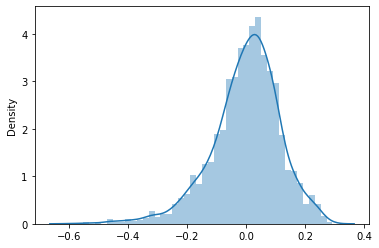

In [116]:
sns.distplot(Y_test-pred_test_model2)

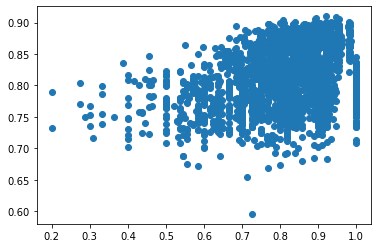

In [117]:
plt.scatter(Y_test,pred_test_model2)

Finally we combine all the features. The new model gives a much better score than other models for short term memorability but not such a good score for long term memorability. The best long term memorability was achieved by the model trained on feature set comprising of HMP , C3D and aesthetic mean features.

In [59]:
# All the features
X_2 = np.hstack((X1,X2,X3,X4,X5,X6,X7))

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X_2,Y, test_size=0.2, random_state=42)

In [52]:
Y = labels[['short-term_memorability','long-term_memorability']].values

In [62]:
#HMP, C3D ,Aesthetic mean,Aesthetic mean, InceptionV3 all samples(SECOND RUN)
model3 = RandomForestRegressor()
model3.fit(X_train,Y_train)
pred_test_model3 = model3.predict(X_test)
Get_score(pred_test_model3, Y_test)

The Spearman's correlation coefficient is: 0.330
The Spearman's correlation coefficient is: 0.135


In [113]:
#HMP, C3D ,Aesthetic mean,Aesthetic mean, InceptionV3 all samples(THIRD RUN)
model3 = RandomForestRegressor()
model3.fit(X_train,Y_train)
pred_test_model3 = model3.predict(X_test)
Get_score(pred_test_model3, Y_test)

The Spearman's correlation coefficient is: 0.324
The Spearman's correlation coefficient is: 0.132


In [163]:
#HMP, C3D ,Aesthetic mean,Aesthetic mean, InceptionV3 all samples(FIRST RUN)
model3 = RandomForestRegressor()
model3.fit(X_train,Y_train)
pred_test_model3 = model3.predict(X_test)
Get_score(pred_test_model3, Y_test)

The Spearman's correlation coefficient is: 0.352
The Spearman's correlation coefficient is: 0.116


c:\users\i318517\desktop\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


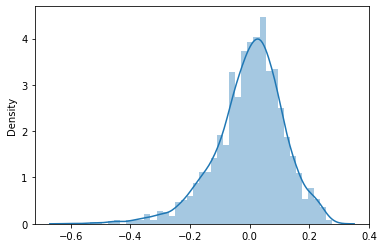

In [114]:
import seaborn as sns
sns.distplot(Y_test-pred_test_model3)

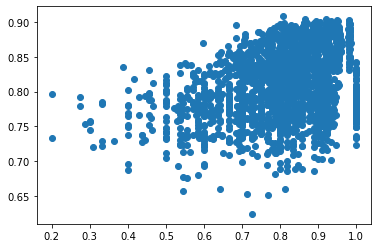

In [115]:
plt.scatter(Y_test,pred_test_model3)

# Train models for final prediction of test data. Here we train models on the entire train dataset

In [63]:
# model to long term memorability score - here we are using the C3D , HMP and Aesthetic mean features
LTmodel = RandomForestRegressor()
LTmodel.fit(X_1,Y)

RandomForestRegressor()

In [64]:
# model to predict short term memorability - here the feature set comprises of all the models
STmodel = RandomForestRegressor()
STmodel.fit(X_2,Y)

RandomForestRegressor()

# Hyper paramenter tuning

I wanted to do hyperparameter tuning for model3(trained on all features) and model2(trained on HMP,C3D and aesthetic mean). It observed that when we create new models on the same feature set the Spearman score varied quite a bit for these models. This gave an indication that model performance could improve after Hyper Parameter Optimization.
I used Randomized Search CV and it ran for more than 24 hours(probably because of the high number of features) and I had to kill the process as it was taking too much time. If I had more time I would want to compare the accuracy of my base models to randomized search models.Below are the steps for the execution of Hyper parameter tuning and comparison between base models and 
models trained with parameters from RandomizedSearchCV

In [165]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#Using the random grid to search for the best hyperparameters
#creating a base model to train
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
#display best params
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
#get the accuracy for the model without hyper paramenter turing
base_accuracy = evaluate(model3, X_test, Y_test)

In [ ]:
#get accuracy of model with hyper paramenter tuning
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, X_test)

In [ ]:
#check for improvement after hyperparameter tuning
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

# get test-set features


In [65]:
ground_truth_file = 'C:\\Users\\i318517\\Desktop\\MSC\\Machine Learning\\CA684_Assignment\\Test-set\\Ground-truth_test\\ground_truth_template.csv'
#ground_truth_file = r"C:\Users\i318517\Desktop\MSC\Machine Learning\CA684_Assignment\Dev-set\Ground-truth\ground-truth_dev-set.csv"
test_video_labels = pd.read_csv(ground_truth_file)
test_video_labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [66]:
test_video_labels.dtypes

video                          int64
short-term_memorability      float64
nb_short-term_annotations      int64
long-term_memorability       float64
nb_long-term_annotations       int64
dtype: object

In [67]:
test_video_labels['video'] = test_video_labels['video'].astype(str)

In [68]:
test_vid = test_video_labels.video.values

In [69]:
C3D_Feat_path_test = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Test-set/'
C3D_Features_test = pd.DataFrame({'video': test_vid,
                   'C3D': [read_C3D(C3D_Feat_path_test+'C3D_test'+'/'+ 'video' + 
                                    os.path.splitext(item)[0]+'.txt') for item in test_vid],
                       })

In [70]:
C3D_Features_test.head()

,video,C3D
0,7494,"[0.00013576, 0.0002133, 0.00124759, 1.149e-05,..."
1,7495,"[0.00012659, 2.377e-05, 0.04950115, 2.418e-05,..."
2,7496,"[0.48898152, 0.00058536, 2.454e-05, 0.00016031..."
3,7497,"[0.24925078, 0.00101763, 8.02e-06, 1.92e-05, 2..."
4,7498,"[0.00989415, 3.413e-05, 0.00261261, 2.1e-06, 1..."


In [71]:
C3D_Features_test.shape

(2000, 2)

In [72]:
HMP_Feat_path_test = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Test-set/'
HMP_Features_test = pd.DataFrame({'video': test_vid,
                   'HMP': [read_HMP(HMP_Feat_path_test+'HMP_test'+'/'+'video' + os.path.splitext(item)[0]+'.txt') for item in test_vid],
                       })

In [73]:
HMP_Features_test.head()

,video,HMP
0,7494,"[0.022039, 0.005264, 9.8e-05, 0.0, 0.003689, 0..."
1,7495,"[0.004694, 0.001934, 4e-05, 0.0, 0.001226, 5.8..."
2,7496,"[0.02653, 0.006208, 5.8e-05, 0.0, 0.00228, 3.1..."
3,7497,"[0.045109, 0.008317, 0.000151, 0.0, 0.005598, ..."
4,7498,"[0.034691, 0.008619, 0.000412, 0.0, 0.028355, ..."


In [74]:
aesthetic_path_test = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Test-set/aesthetic_vis_features_test/'
aesthetic_features_mean_test = pd.DataFrame({'video': test_vid,
                   'aesthetic_mean': [read_aesthetic_features(aesthetic_path_test+'mean'+'/'+ 'video' + os.path.splitext(item)[0]+'.txt') for item in test_vid],
                       })

aesthetic_features_median_test = pd.DataFrame({'video': test_vid,
                   'aesthetic_median': [read_aesthetic_features(aesthetic_path_test+'median'+'/'+ 'video' +os.path.splitext(item)[0]+'.txt') for item in test_vid],
                       })


In [75]:
aesthetic_features_mean_test.head()

,video,aesthetic_mean
0,7494,"[0.15188, 0.435622, 0.385821, 0.324642, 0.3163..."
1,7495,"[0.346129, 0.39686, 0.518731, 0.417674, 0.4222..."
2,7496,"[0.126344, 0.225354, 0.479295, 0.172265, 0.432..."
3,7497,"[0.217836, 0.338128, 0.633791, 0.245464, 0.529..."
4,7498,"[0.436468, 0.292819, 0.4736, 0.270421, 0.40387..."


In [76]:
aesthetic_features_median_test.head()

,video,aesthetic_median
0,7494,"[0.151128, 0.428798, 0.388939, 0.319523, 0.319..."
1,7495,"[0.351501, 0.38728, 0.52406, 0.410809, 0.42906..."
2,7496,"[0.126592, 0.225055, 0.479929, 0.172715, 0.432..."
3,7497,"[0.218887, 0.337801, 0.633643, 0.245733, 0.529..."
4,7498,"[0.438498, 0.290777, 0.474659, 0.267142, 0.403..."


In [83]:
#read InceptionV3 features
def read_InceptionV3(fname):
    """Scan features from file"""
    #fname = fname + '-0' + '.txt' # extract the first sample
    #fname = fname + '-56' + '.txt' # extract the second sample
    fname = fname + '-112' + '.txt' #extract the third sample
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            IV3_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    IV3 = np.zeros(6075)
    for idx in IV3_temp.keys():
        IV3[idx-1] = IV3_temp[idx]            
    return IV3

In [78]:
InceptionV3_path_test = 'C:/Users/i318517/Desktop/MSC/Machine Learning/CA684_Assignment/Test-set/'

InceptionV3_features_0_test = pd.DataFrame({'video': test_vid,
                   'InceptionV3_0': [read_InceptionV3(InceptionV3_path_test+'Inception_test'+'/'+ 'video' +os.path.splitext(item)[0]) for item in test_vid],
                       })



In [80]:
InceptionV3_features_0_test.head()

,video,InceptionV3_0
0,7494,"[6.507684e-26, 9.451245e-23, 3.503505e-24, 7.4..."
1,7495,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7496,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,7497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7498,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [81]:
InceptionV3_features_1_test = pd.DataFrame({'video': test_vid,
                   'InceptionV3_1': [read_InceptionV3(InceptionV3_path_test+'Inception_test'+'/'+ 'video' +os.path.splitext(item)[0]) for item in test_vid],
                       })


In [82]:
InceptionV3_features_1_test.head()

,video,InceptionV3_1
0,7494,"[7.820061e-26, 4.141834e-23, 4.825725e-27, 8.9..."
1,7495,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7496,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,7497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7498,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [84]:

InceptionV3_features_2_test = pd.DataFrame({'video': test_vid,
                   'InceptionV3_2': [read_InceptionV3(InceptionV3_path_test+'Inception_test'+'/'+ 'video' +os.path.splitext(item)[0]) for item in test_vid],
                       })

In [85]:
InceptionV3_features_2_test.head()

,video,InceptionV3_2
0,7494,"[3.274185e-29, 2.647296e-25, 8.844853e-29, 3.4..."
1,7495,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7496,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,7497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7498,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [86]:
A = np.stack(C3D_Features_test['C3D'].values)
B = np.stack(HMP_Features_test['HMP'].values)
C = np.stack(aesthetic_features_mean_test['aesthetic_mean'].values)
D = np.stack(aesthetic_features_median_test['aesthetic_median'].values)
E = np.stack(InceptionV3_features_0_test['InceptionV3_0'].values)
F = np.stack(InceptionV3_features_1_test['InceptionV3_1'].values)
G = np.stack(InceptionV3_features_2_test['InceptionV3_2'].values)

In [87]:
# stack all features use the model trained on all the features which will be used to predict  short term memorability
x_test = np.hstack((A,B,C,D,E,F,G))

In [88]:
# stack HMP, C3D and aesthetic mean test features which will be used to predict long term memorability
x_test2 = np.hstack((A,B,C))

# Prediction for Test Data

In [89]:
# predict memorabilty using model 'STmodel'. The short term memorability prediction of this model
#will be used for the submission
pred1  = STmodel.predict(x_test)

In [97]:
mem_scores =pd.DataFrame()

In [98]:
mem_scores['short_term_memorability'] = pred1[:,0]

In [91]:
# predict memorabilty using model 'LTmodel'. The long term memorability prediction of this model
#will be used for thesubmission
pred2 = LTmodel.predict(x_test2)

In [102]:
mem_scores['long_term_memorability'] = pred2[:,1]

In [105]:
mem_scores.head()

,short_term_memorability,long_term_memorability
0,0.85835,0.78044
1,0.81544,0.79011
2,0.87274,0.75221
3,0.88702,0.80068
4,0.84078,0.77894


In [106]:
mem_scores.shape

(2000, 2)

In [107]:
test_video_labels.columns

Index(['video', 'short-term_memorability', 'nb_short-term_annotations',
       'long-term_memorability', 'nb_long-term_annotations'],
      dtype='object')

In [108]:
test_video_labels['short-term_memorability'] = mem_scores['short_term_memorability']
test_video_labels['long-term_memorability'] = mem_scores['long_term_memorability']

In [109]:
#create submission file with short term and long term memorability predictions
test_video_labels.to_csv('Kushagra_Srivastava_20214989_predictions.csv')

In [111]:
import pickle
filename1 = 'STmodel.sav'
pickle.dump(STmodel, open(filename1, 'wb'))

In [112]:
filename2 = 'LTmodel.sav'
pickle.dump(LTmodel, open(filename2, 'wb'))